In [3]:
%run dfmux_calc.py

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# base SA13 parameters
zt_sa13 = 1500.
rdyn_sa13 = 400.
noise_sa13 = 1e-12
lin_sa13 = 70e-9
power_sa13 = 200e-9

In [6]:
# SA13 single-bank parameters
zt_bank = zt_sa13 / 3.
rdyn_bank = rdyn_sa13 / 3. * 2
noise_bank = noise_sa13 * np.sqrt(6)
lin_bank = lin_sa13 / 6
power_bank = power_sa13 / 6.

In [7]:
# note on conventions:
# n_s = number of outputs in series
# n_p = number of outputs in parallel

# define maximum n_s, n_p
n_s_max = 7
n_p_max = 7

# get list of n_s, n_p
x = np.meshgrid(range(1, n_s_max), range(1, n_p_max))
n_s = x[0].ravel()
n_p = x[1].ravel()
N = n_s * n_p # total number of banks

In [8]:
# calculate squid parameters for each set of n_s, n_p
lins = lin_bank * N
rdyns = rdyn_bank * (n_s/n_p)
noises = noise_bank / np.sqrt(N)
zts = zt_bank * (n_s)
powers = power_bank * N

In [9]:
N

array([ 1,  2,  3,  4,  5,  6,  2,  4,  6,  8, 10, 12,  3,  6,  9, 12, 15,
       18,  4,  8, 12, 16, 20, 24,  5, 10, 15, 20, 25, 30,  6, 12, 18, 24,
       30, 36])

In [10]:
# calculate noise for each set of n_s, n_p
neis = np.full(len(N), np.nan)
for i, (lin, rdyn, zt, noise, power) in enumerate(zip(lins, rdyns, zts, noises, powers)):
    dfmux = DfMux(freqs = np.linspace(1.5e6, 5.5e6, 68),
                  bolo = Bolometer(r=1., tc=0.),
                  carrier = CarrierChain(t_bias=.0),
                  demod = DemodChain(),
                  nuller = NullerChain(),
                  squid = SQUID(zt = zt,
                                rdyn = rdyn,
                                lin = lin,
                                noise_squid_only = noise)
                 )
    dfmux.calc_noise()
    neis[i] = np.median(dfmux.total_noise)

In [11]:
# sometimes multiple configurations produce the same power dissipation
# find the unique power dissipation values
powers_unique = np.unique(powers)

In [12]:
# find the mimiminum NEI for each unique power value
nei_min = np.array([np.amin(neis[powers==p]) for p in powers_unique])

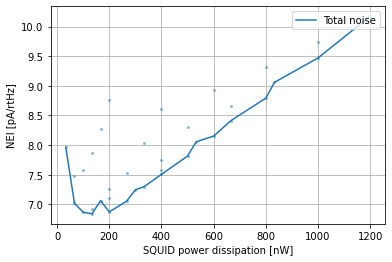

In [13]:
# plot noise vs power
plt.plot(powers*1e9, neis*1e12, '.', alpha=.5, markeredgewidth=0., color='C0')
plt.plot(powers_unique*1e9, nei_min*1e12, color='C0', label='Total noise')
#plt.axhline(np.sqrt(dfmux.carrier.total_noise**2+dfmux.nuller.total_noise**2)[0]*1e12, label='Carrier & nuller noise', color='C1')
plt.legend(loc='upper right')
#plt.ylim(4, 15) 
plt.grid()
plt.xlabel('SQUID power dissipation [nW]')
plt.ylabel('NEI [pA/rtHz]')
plt.show()

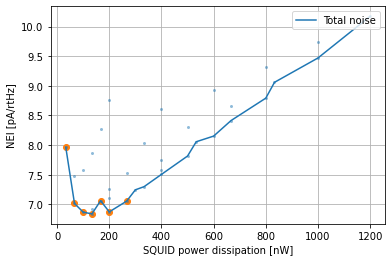

In [14]:
for j in range(7):
    plt.plot(powers_unique[j]*1e9, nei_min[j]*1e12, 'o', color='C1')

plt.plot(powers*1e9, neis*1e12, '.', alpha=.5, markeredgewidth=0., color='C0')
plt.plot(powers_unique*1e9, nei_min*1e12, color='C0', label='Total noise')

#plt.axhline(np.sqrt(dfmux.carrier.total_noise**2+dfmux.nuller.total_noise**2)[0]*1e12, label='Carrier & nuller noise', color='C1')
plt.legend(loc='upper right')
#plt.ylim(4, 15) 
plt.grid()
plt.xlabel('SQUID power dissipation [nW]')
plt.ylabel('NEI [pA/rtHz]')
plt.show()

N_s x N_p of points following solid line from left to right:
- 1x1
- 2x1
- 3x1
- 2x2
- 5x1
- 3x2
- 4x2

Nicole's stuff


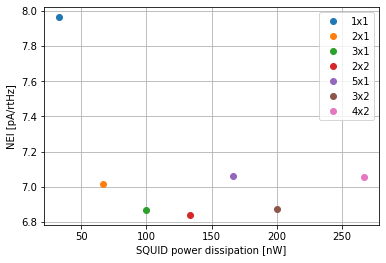

In [15]:
labels = ['1x1', '2x1', "3x1", "2x2", "5x1", "3x2", "4x2"]
for j in range(7):
    plt.plot(powers_unique[j]*1e9, nei_min[j]*1e12, 'o', label=labels[j])
plt.legend(loc='upper right')
#plt.ylim(4, 15) 
plt.grid()
plt.xlabel('SQUID power dissipation [nW]')
plt.ylabel('NEI [pA/rtHz]')
plt.show()

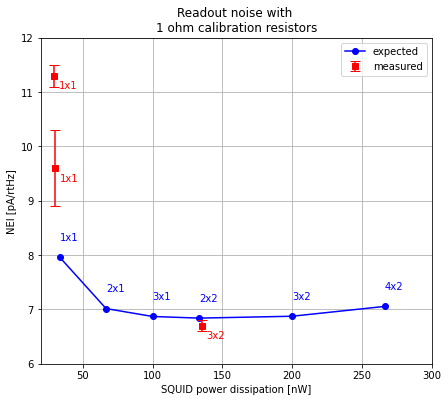

In [56]:
# Predicted NEI
my_squids = ['1x1', '2x1', "3x1", "2x2", "3x2", "4x2"]
exp_power = np.array([power for power, label in zip(powers_unique, labels)
    if label in my_squids ])
exp_nei = np.array([noise for noise, label in zip(nei_min, labels)
    if label in my_squids ])


    
# Measured NEI
meas_power = [30, 29, 135.1]
meas_nei = np.array([9.6 , 11.3 , 6.7])
meas_nei_sigma = np.array( [0.7, 0.2 , 0.1 ])
meas_squids = ["1x1", "1x1", "3x2"]
    
plt.figure(1, figsize=(7,6))
plt.plot(exp_power*1e9, exp_nei*1e12, "o-", label="expected", color='blue')
plt.errorbar(meas_power, meas_nei, yerr=meas_nei_sigma, capsize=5, fmt='s', color='red', label='measured')

# Annotate
for j in range(0, len(my_squids)):
    x = exp_power[j]*1e9
    y = exp_nei[j]*1e12
    
    plt.annotate(
    my_squids[j],              # text
    xy=(x, y),              # point (used for alignment if needed)
    xytext=(0, +15),          # offset in points
    textcoords='offset points',
    ha='left',              # horizontal alignment
    va='bottom',             # vertical alignment
    color='blue'
)
    
for j in range(0, len(meas_squids)):
    
    x = meas_power[j]
    y = meas_nei[j]
    
    plt.annotate(
    meas_squids[j],              # text
    xy=(x, y),              # point (used for alignment if needed)
    xytext=(5, -15),          # offset in points
    textcoords='offset points',
    ha='left',              # horizontal alignment
    va='bottom',             # vertical alignment
    color='red'
)
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('SQUID power dissipation [nW]')
plt.ylabel('NEI [pA/rtHz]')
plt.title("Readout noise with \n1 ohm calibration resistors")
plt.xlim(20, 300)
plt.ylim([6.0, 12])
plt.show()